In [1]:
import skimage
import cv2
from matplotlib import pyplot as plt
import numpy as np
import os
# There is a Crop layer that the HED network uses which is not implemented by 
# default so we need to provide our own implementation of this layer.
#Without the crop layer, the final result will be shifted to the right and bottom
#cropping part of the image
class CropLayer(object):
    def __init__(self, params, blobs):
        # initialize our starting and ending (x, y)-coordinates of
        # the crop
        self.startX = 0
        self.startY = 0
        self.endX = 0
        self.endY = 0

    def getMemoryShapes(self, inputs):
        # the crop layer will receive two inputs -- we need to crop
        # the first input blob to match the shape of the second one,
        # keeping the batch size and number of channels
        (inputShape, targetShape) = (inputs[0], inputs[1])
        (batchSize, numChannels) = (inputShape[0], inputShape[1])
        (H, W) = (targetShape[2], targetShape[3])

        # compute the starting and ending crop coordinates
        self.startX = int((inputShape[3] - targetShape[3]) / 2)
        self.startY = int((inputShape[2] - targetShape[2]) / 2)
        self.endX = self.startX + W
        self.endY = self.startY + H

        # return the shape of the volume (we'll perform the actual
        # crop during the forward pass
        return [[batchSize, numChannels, H, W]]

    def forward(self, inputs):
        # use the derived (x, y)-coordinates to perform the crop
        return [inputs[0][:, :, self.startY:self.endY,
                self.startX:self.endX]]
# The pre-trained model that OpenCV uses has been trained in Caffe framework
#Download from the link above
protoPath = "deploy.prototxt"
modelPath = "hed_pretrained_bsds.caffemodel"
net = cv2.dnn.readNetFromCaffe(protoPath, modelPath)

# register our crop layer with the model
cv2.dnn_registerLayer("Crop", CropLayer)


In [3]:
# load the input image and grab its dimensions, for future use while defining the blob
img = cv2.imread("F1-s007Box-1-A3.jpg")
print(img.shape)
(H, W) = img.shape[:2]
# construct a blob out of the input image 
mean_pixel_values= np.average(img, axis = (0,1))
blob = cv2.dnn.blobFromImage(img, scalefactor=0.7, size=(W, H),
                             #mean=(mean_pixel_values[0], mean_pixel_values[1], mean_pixel_values[2]),
                             mean=(105, 117, 123),
                             swapRB= False, crop=False)
# set the blob as the input to the network and perform a forward pass
# to compute the edges
net.setInput(blob)
hed = net.forward()
hed = hed[0,0,:,:]  #Drop the other axes 
hed = (255 * hed).astype("uint8")  #rescale to 0-255
# Load segmented binary image, Gaussian blur, grayscale, Otsu's threshold
blur = cv2.GaussianBlur(hed, (7,7), 0)
blur = cv2.GaussianBlur(blur, (7,7), 0)
thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
# Perform connected component labeling
n_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(thresh, connectivity=4)

# Create false color image with black background and colored objects
colors = np.random.randint(0, 255, size=(n_labels, 3), dtype=np.uint8)
colors[0] = [0, 0, 0]  # black background
false_colors = colors[labels]
edges= cv2.Canny(false_colors, 50,200)

contours, hierarchy= cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
print ('Number of contours found = ', len(contours))


def get_contour_areas(contours):

    all_areas= []

    for cnt in contours:
        area= cv2.contourArea(cnt)
        all_areas.append(area)

    return all_areas


sorted_contours= sorted(contours, key=cv2.contourArea, reverse= True)


smallest_item= sorted_contours[0]

cv2.drawContours(img_copy, smallest_item, -1, (255,255,0),1)
cv2.drawContours(c, smallest_item, -1, (100,0,0),1)
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, squeeze=True)
axes[0, 0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
axes[0, 1].imshow(img_copy)
axes[1, 0].imshow(c)
axes[1, 1].imshow(hed)

plt.show()

(480, 640, 3)
Number of contours found =  12


NameError: name 'img_copy' is not defined

In [67]:
c=np.zeros(hed.shape, np.uint8)
img_copy=img
thresh = cv2.threshold(c, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
cv2.imshow('sd',thresh)
mask=cv2.bitwise_not(thresh)
cv2.imshow('sdxd',mask)

cv2.waitKey(0)
cv2.destroyAllWindows()
indices = np.where(mask != [0])
coordinates=list(map(list, zip(indices[0], indices[1])))




In [73]:
def f(path):
    fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, squeeze=True)
    # load the input image and grab its dimensions, for future use while defining the blob
    img = cv2.imread(path)
    a=img
    axes[0, 0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    (H, W) = img.shape[:2]
    # construct a blob out of the input image 
    mean_pixel_values= np.average(img, axis = (0,1))
    blob = cv2.dnn.blobFromImage(img, scalefactor=0.7, size=(W, H),
                                 #mean=(mean_pixel_values[0], mean_pixel_values[1], mean_pixel_values[2]),
                                 mean=(105, 117, 123),
                                 swapRB= False, crop=False)
    # set the blob as the input to the network and perform a forward pass
    # to compute the edges
    net.setInput(blob)
    hed = net.forward()
    hed = hed[0,0,:,:]  #Drop the other axes 
    hed = (255 * hed).astype("uint8")  #rescale to 0-255
    # Load segmented binary image, Gaussian blur, grayscale, Otsu's threshold
    blur = cv2.GaussianBlur(hed, (7,7), 0)
    blur = cv2.GaussianBlur(blur, (7,7), 0)
    thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    # Perform connected component labeling
    n_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(thresh, connectivity=4)

    # Create false color image with black background and colored objects
    colors = np.random.randint(0, 255, size=(n_labels, 3), dtype=np.uint8)
    colors[0] = [0, 0, 0]  # black background
    false_colors = colors[labels]
    edges= cv2.Canny(false_colors, 50,200)

    contours, hierarchy= cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    print ('Number of contours found = ', len(contours))


    def get_contour_areas(contours):

        all_areas= []

        for cnt in contours:
            area= cv2.contourArea(cnt)
            all_areas.append(area)

        return all_areas


    sorted_contours= sorted(contours, key=cv2.contourArea, reverse= True)


    largest_item= sorted_contours[0]
    binary_mask=np.zeros(hed.shape, np.uint8)
    img_copy=img
    cv2.drawContours(img_copy, largest_item, -1, (255,255,0),1)
    cv2.drawContours(binary_mask, largest_item, -1, (100,0,0),1)
   
    axes[0, 1].imshow(hed)
    axes[1, 0].imshow(binary_mask)
    axes[1, 1].imshow(img_copy)
    plt.show()

   

Number of contours found =  14


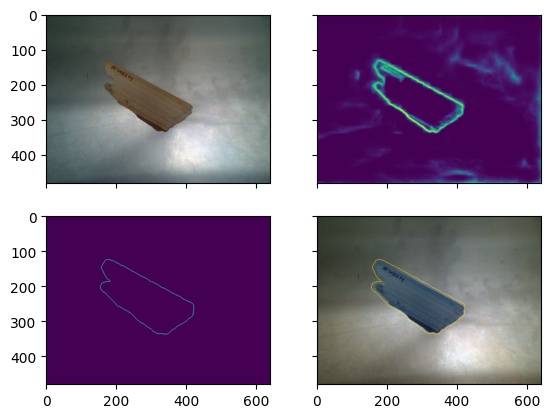

In [75]:
f("Wood_Class_A1_Box2-s2.jpg")

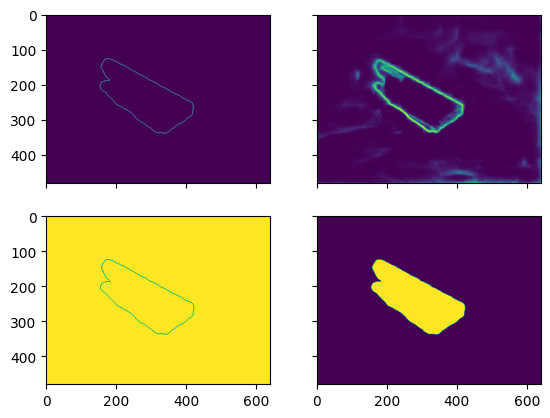

<Figure size 640x480 with 0 Axes>

In [21]:
# a trial to generate a binary mask back from the generated coordinates method 1
thresh = cv2.threshold(binary_mask, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

mask=cv2.bitwise_not(thresh)
c_x, c_y = mask.nonzero()
# Test if all points are ones
rr, cc = skimage.draw.polygon(c_x, c_y)

fi, axe = plt.subplots(2, 2, sharex=True, sharey=True, squeeze=True)
k=np.zeros(hed.shape, np.uint8)
k[rr, cc] = 1
axe[0, 0].imshow(mask)
axe[0, 1].imshow(hed)
axe[1, 0].imshow(thresh)
axe[1, 1].imshow(k)

plt.show()


In [8]:
# a trial to generate a binary mask back from the generated coordinates method 2
thresh = cv2.threshold(binary_mask, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
cv2.imshow('sd',thresh)
mask=cv2.bitwise_not(thresh)
indices = np.where(mask != [0])
coordinates=list(map(list, zip(indices[0], indices[1])))
c1=[]
c2=[]
for i in coordinates:
    #print(i)
    c1.append(i[0])
    c2.append(i[1])
c1=np.array(c1)
c2=np.array(c2)
rr, cc = skimage.draw.polygon(c1, c2)

fi, axe = plt.subplots(2, 2, sharex=True, sharey=True, squeeze=True)
k=np.zeros(hed.shape, np.uint8)
k[rr, cc] = 1
axe[0, 0].imshow(mask)
axe[0, 1].imshow(hed)
axe[1, 0].imshow(thresh)
axe[1, 1].imshow(k)
plt.show()

NameError: name 'binary_mask' is not defined

In [6]:
def maskki(path,filename):
    fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, squeeze=True)
    fig.suptitle(filename)
    # load the input image and grab its dimensions, for future use while defining the blob
    img = cv2.imread(path)
    a=img
    axes[0, 0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    (H, W) = img.shape[:2]
    # construct a blob out of the input image 
    mean_pixel_values= np.average(img, axis = (0,1))
    blob = cv2.dnn.blobFromImage(img, scalefactor=0.7, size=(W, H),
                                 #mean=(mean_pixel_values[0], mean_pixel_values[1], mean_pixel_values[2]),
                                 mean=(105, 117, 123),
                                 swapRB= False, crop=False)
    # set the blob as the input to the network and perform a forward pass
    # to compute the edges
    net.setInput(blob)
    hed = net.forward()
    hed = hed[0,0,:,:]  #Drop the other axes 
    hed = (255 * hed).astype("uint8")  #rescale to 0-255
    # Load segmented binary image, Gaussian blur, grayscale, Otsu's threshold
    blur = cv2.GaussianBlur(hed, (7,7), 0)
    blur = cv2.GaussianBlur(blur, (7,7), 0)
    thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    # Perform connected component labeling
    n_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(thresh, connectivity=4)

    # Create false color image with black background and colored objects
    colors = np.random.randint(0, 255, size=(n_labels, 3), dtype=np.uint8)
    colors[0] = [0, 0, 0]  # black background
    false_colors = colors[labels]
    edges= cv2.Canny(false_colors, 50,200)

    contours, hierarchy= cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    print ('Number of contours found = ', len(contours))


    def get_contour_areas(contours):

        all_areas= []

        for cnt in contours:
            area= cv2.contourArea(cnt)
            all_areas.append(area)

        return all_areas


    sorted_contours= sorted(contours, key=cv2.contourArea, reverse= True)


    largest_item= sorted_contours[0]
    binary_mask=np.zeros(hed.shape, np.uint8)
    img_copy=img
    cv2.drawContours(img_copy, largest_item, -1, (255,255,0),1)
    cv2.drawContours(binary_mask, largest_item, -1, (100,0,0),1)
    thresh = cv2.threshold(binary_mask, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    mask=cv2.bitwise_not(thresh)
    axes[1, 0].imshow(mask)
    indices = np.where(mask != [0])
    coordinates=list(map(list, zip(indices[0], indices[1])))
    axes[0, 1].imshow(hed)
    axes[1, 1].imshow(img_copy)
    plt.savefig(os.path.join( 'label', f'{filename.split(".")[0]}.jpg'))
    plt.show()


for image in os.listdir('test'):
        print(os.path.join('test',image))
        maskki(os.path.join('test',image),image)


In [14]:
# to convert a file of images to pdf
from fpdf import FPDF
path = 'C:/Users/Jerardh Josekutty/Desktop/hed_final/label/' # get the path of images

imagelist = os.listdir('label') # get list of all images

pdf = FPDF('P','mm','A4') # create an A4-size pdf document 

x,y,w,h = 0,0,200,250

for image in imagelist:

    pdf.add_page()
    pdf.image(path+image,x,y,w,h)

pdf.output("mask_for_all_dataset.pdf", "F")

''

test\F1-s007Box-1-A3.jpg
Number of contours found =  12


FileNotFoundError: [Errno 2] No such file or directory: 'label\\F1-s007Box-1-A3.jpg'

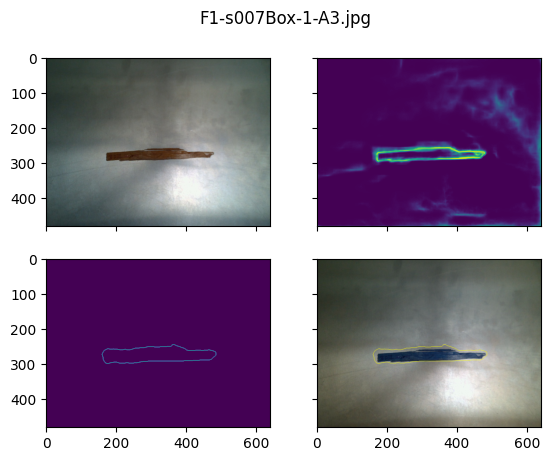

In [1]:
#using hed to detect the contour
import skimage
import cv2
from matplotlib import pyplot as plt
import numpy as np
import os
# There is a Crop layer that the HED network uses which is not implemented by 
# default so we need to provide our own implementation of this layer.
#Without the crop layer, the final result will be shifted to the right and bottom
#cropping part of the image
class CropLayer(object):
    def __init__(self, params, blobs):
        # initialize our starting and ending (x, y)-coordinates of
        # the crop
        self.startX = 0
        self.startY = 0
        self.endX = 0
        self.endY = 0

    def getMemoryShapes(self, inputs):
        # the crop layer will receive two inputs -- we need to crop
        # the first input blob to match the shape of the second one,
        # keeping the batch size and number of channels
        (inputShape, targetShape) = (inputs[0], inputs[1])
        (batchSize, numChannels) = (inputShape[0], inputShape[1])
        (H, W) = (targetShape[2], targetShape[3])

        # compute the starting and ending crop coordinates
        self.startX = int((inputShape[3] - targetShape[3]) / 2)
        self.startY = int((inputShape[2] - targetShape[2]) / 2)
        self.endX = self.startX + W
        self.endY = self.startY + H

        # return the shape of the volume (we'll perform the actual
        # crop during the forward pass
        return [[batchSize, numChannels, H, W]]

    def forward(self, inputs):
        # use the derived (x, y)-coordinates to perform the crop
        return [inputs[0][:, :, self.startY:self.endY,
                self.startX:self.endX]]
# The pre-trained model that OpenCV uses has been trained in Caffe framework
#Download from the link above
protoPath = "deploy.prototxt"
modelPath = "hed_pretrained_bsds.caffemodel"
net = cv2.dnn.readNetFromCaffe(protoPath, modelPath)

# register our crop layer with the model
cv2.dnn_registerLayer("Crop", CropLayer)

#this function saves the image generated by matplotlib to a seperate folder
# this function can be modified for any puprpose , generating labels in any format
#for each type of dataset based on lighting condition, the post processing after hed 
#should be adjusted

def maskki(path,filename):
    fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, squeeze=True)
    fig.suptitle(filename)
    # load the input image and grab its dimensions, for future use while defining the blob
    img = cv2.imread(path)
    a=img
    axes[0, 0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    (H, W) = img.shape[:2]
    # construct a blob out of the input image 
    mean_pixel_values= np.average(img, axis = (0,1))
    blob = cv2.dnn.blobFromImage(img, scalefactor=0.7, size=(W, H),
                                 #mean=(mean_pixel_values[0], mean_pixel_values[1], mean_pixel_values[2]),
                                 mean=(105, 117, 123),
                                 swapRB= False, crop=False)
    # set the blob as the input to the network and perform a forward pass
    # to compute the edges
    net.setInput(blob)
    hed = net.forward()
    hed = hed[0,0,:,:]  #Drop the other axes 
    hed = (255 * hed).astype("uint8")  #rescale to 0-255
    # Load segmented binary image, Gaussian blur, grayscale, Otsu's threshold
    blur = cv2.GaussianBlur(hed, (7,7), 0)
    blur = cv2.GaussianBlur(blur, (7,7), 0)
    thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    # Perform connected component labeling
    n_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(thresh, connectivity=4)

    # Create false color image with black background and colored objects
    colors = np.random.randint(0, 255, size=(n_labels, 3), dtype=np.uint8)
    colors[0] = [0, 0, 0]  # black background
    false_colors = colors[labels]
    edges= cv2.Canny(false_colors, 50,200)

    contours, hierarchy= cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    print ('Number of contours found = ', len(contours))


    def get_contour_areas(contours):

        all_areas= []

        for cnt in contours:
            area= cv2.contourArea(cnt)
            all_areas.append(area)

        return all_areas


    sorted_contours= sorted(contours, key=cv2.contourArea, reverse= True)


    largest_item= sorted_contours[0]
    binary_mask=np.zeros(hed.shape, np.uint8)
    img_copy=img
    cv2.drawContours(img_copy, largest_item, -1, (255,255,0),1)
    cv2.drawContours(binary_mask, largest_item, -1, (100,0,0),1)
    thresh = cv2.threshold(binary_mask, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    mask=cv2.bitwise_not(thresh)
    axes[1, 0].imshow(mask)
    indices = np.where(mask != [0])
    coordinates=list(map(list, zip(indices[0], indices[1])))
    axes[0, 1].imshow(hed)
    axes[1, 1].imshow(img_copy)
    plt.savefig(os.path.join( 'label', f'{filename.split(".")[0]}.jpg'))
    plt.show()


for image in os.listdir('test'):
        print(os.path.join('test',image))
        maskki(os.path.join('test',image),image)


In [1]:
#using hed to detect the contour
import skimage
import cv2
from matplotlib import pyplot as plt
import numpy as np
import os
import json
# There is a Crop layer that the HED network uses which is not implemented by 
# default so we need to provide our own implementation of this layer.
#Without the crop layer, the final result will be shifted to the right and bottom
#cropping part of the image
class CropLayer(object):
    def __init__(self, params, blobs):
        # initialize our starting and ending (x, y)-coordinates of
        # the crop
        self.startX = 0
        self.startY = 0
        self.endX = 0
        self.endY = 0

    def getMemoryShapes(self, inputs):
        # the crop layer will receive two inputs -- we need to crop
        # the first input blob to match the shape of the second one,
        # keeping the batch size and number of channels
        (inputShape, targetShape) = (inputs[0], inputs[1])
        (batchSize, numChannels) = (inputShape[0], inputShape[1])
        (H, W) = (targetShape[2], targetShape[3])

        # compute the starting and ending crop coordinates
        self.startX = int((inputShape[3] - targetShape[3]) / 2)
        self.startY = int((inputShape[2] - targetShape[2]) / 2)
        self.endX = self.startX + W
        self.endY = self.startY + H

        # return the shape of the volume (we'll perform the actual
        # crop during the forward pass
        return [[batchSize, numChannels, H, W]]

    def forward(self, inputs):
        # use the derived (x, y)-coordinates to perform the crop
        return [inputs[0][:, :, self.startY:self.endY,
                self.startX:self.endX]]
# The pre-trained model that OpenCV uses has been trained in Caffe framework
#Download from the link above
protoPath = "deploy.prototxt"
modelPath = "hed_pretrained_bsds.caffemodel"
net = cv2.dnn.readNetFromCaffe(protoPath, modelPath)

# register our crop layer with the model
cv2.dnn_registerLayer("Crop", CropLayer)

#this function saves the image generated by matplotlib to a seperate folder
# this function can be modified for any puprpose , generating labels in any format
#for each type of dataset based on lighting condition, the post processing after hed 
#should be adjusted
# def layers(class_id,coordinates, image):
#     label= {
#                       "version": "5.1.1",
#                       "flags": {},
#                       "shapes": [
#                         {
#                           "label": class_id,
#                           "points":coordinates,
#                           "group_id":'',
#                           "shape_type": "polygon",
#                           "flags": {}
#                         }
#                       ],
#                       "imagePath":filename,
#                       "imageHeight":int(image1.shape[0]),
#                       "imageWidth": int(image1.shape[1])
#                     }
#     return label  
def maskki(path,filename,class_id):
    fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, squeeze=True)
    fig.suptitle(filename)
    # load the input image and grab its dimensions, for future use while defining the blob
    img = cv2.imread(path)
    a=img
    axes[0, 0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    (H, W) = img.shape[:2]
    # construct a blob out of the input image 
    mean_pixel_values= np.average(img, axis = (0,1))
    blob = cv2.dnn.blobFromImage(img, scalefactor=0.7, size=(W, H),
                                 #mean=(mean_pixel_values[0], mean_pixel_values[1], mean_pixel_values[2]),
                                 mean=(105, 117, 123),
                                 swapRB= False, crop=False)
    # set the blob as the input to the network and perform a forward pass
    # to compute the edges
    net.setInput(blob)
    hed = net.forward()
    hed = hed[0,0,:,:]  #Drop the other axes 
    hed = (255 * hed).astype("uint8")  #rescale to 0-255
    # Load segmented binary image, Gaussian blur, grayscale, Otsu's threshold
    blur = cv2.GaussianBlur(hed, (7,7), 0)
    blur = cv2.GaussianBlur(blur, (7,7), 0)
    thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    # Perform connected component labeling
    n_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(thresh, connectivity=4)

    # Create false color image with black background and colored objects
    colors = np.random.randint(0, 255, size=(n_labels, 3), dtype=np.uint8)
    colors[0] = [0, 0, 0]  # black background
    false_colors = colors[labels]
    edges= cv2.Canny(false_colors, 50,200)

    contours, hierarchy= cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    print ('Number of contours found = ', len(contours))


    def get_contour_areas(contours):

        all_areas= []

        for cnt in contours:
            area= cv2.contourArea(cnt)
            all_areas.append(area)

        return all_areas


    sorted_contours= sorted(contours, key=cv2.contourArea, reverse= True)


    largest_item= sorted_contours[0]
    binary_mask=np.zeros(hed.shape, np.uint8)
    img_copy=img
    cv2.drawContours(img_copy, largest_item, -1, (255,255,0),1)
    cv2.drawContours(binary_mask, largest_item, -1, (100,0,0),1)
    thresh = cv2.threshold(binary_mask, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    mask=cv2.bitwise_not(thresh)
    axes[1, 0].imshow(mask)
    indices = np.where(mask != [0])
    coordinates=list(map(list, zip(indices[1], indices[0])))
    label_json= {
                  "version": "5.1.1",
                  "flags": {},
                  "shapes": [
                    {
                      "label": class_id,
                      "points":coordinates,
                       "group_id":'',
                      "shape_type": "polygon",
                      "flags": {}
                    }
                  ],
                  "imagePath":filename,
                  "imageHeight":int( thresh.shape[0]),
                  "imageWidth": int( thresh.shape[1])
                }
    with open(os.path.join( 'labels', f'{filename.split(".")[0]}.json'), 'w') as f:
                                json.dump(  label_json, f,default=str,indent=1)
    axes[0, 1].imshow(hed)
    axes[1, 1].imshow(img_copy)
    plt.savefig(os.path.join( 'pictures', f'{filename.split(".")[0]}_plot.jpg'))

    plt.show()
   




enter the class id (A1, A2 ,A3)......   A3
test\F1-s031Box-4-A3.jpg
Number of contours found =  11


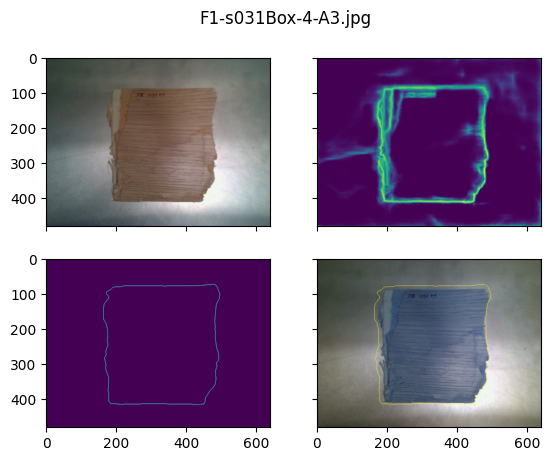

test\F1-s059Box-2-A3.jpg
Number of contours found =  11


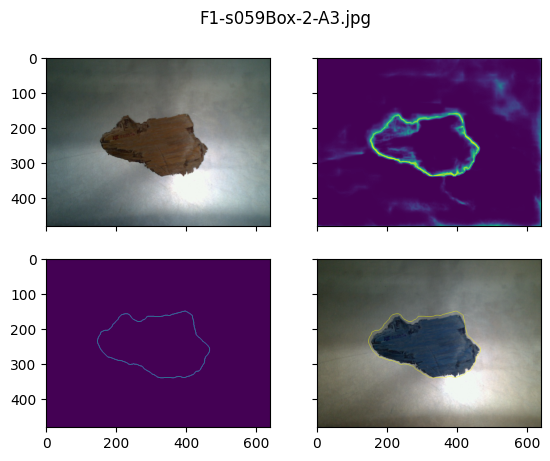

test\F1-s104Box-4-A3.jpg
Number of contours found =  9


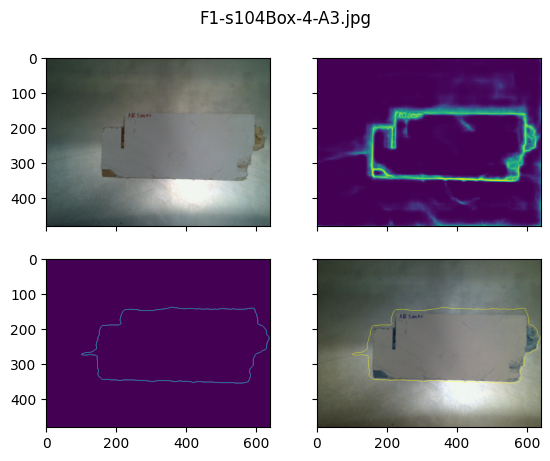

test\F1-s108Box-4-A3.jpg
Number of contours found =  11


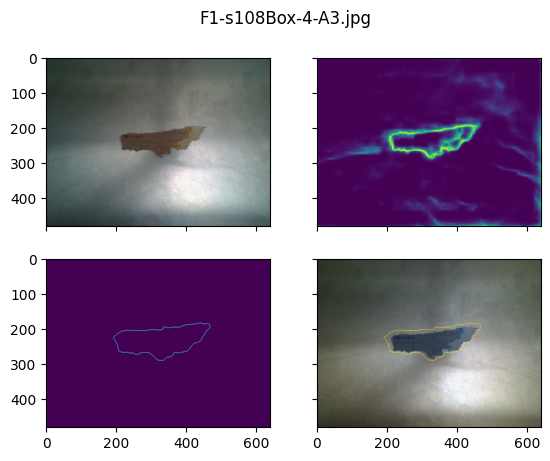

test\F1-s206Box-7-A3.jpg
Number of contours found =  11


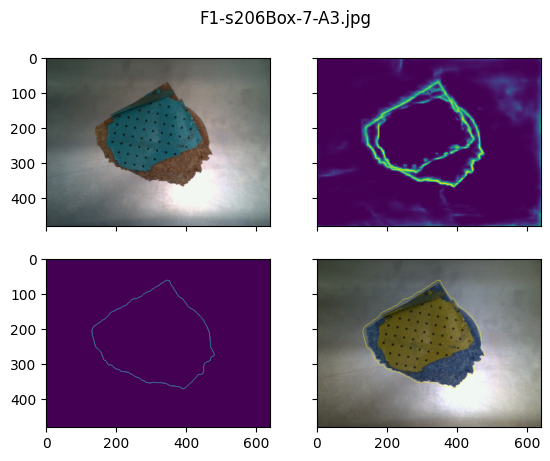

test\F1-s208Box-7-A3.jpg
Number of contours found =  11


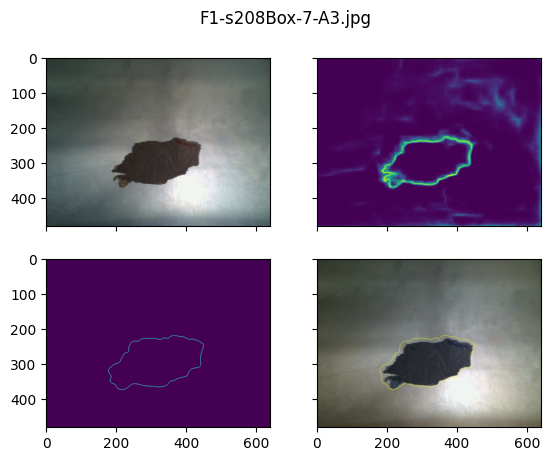

test\F1-s210.1Box-7-A3.jpg
Number of contours found =  12


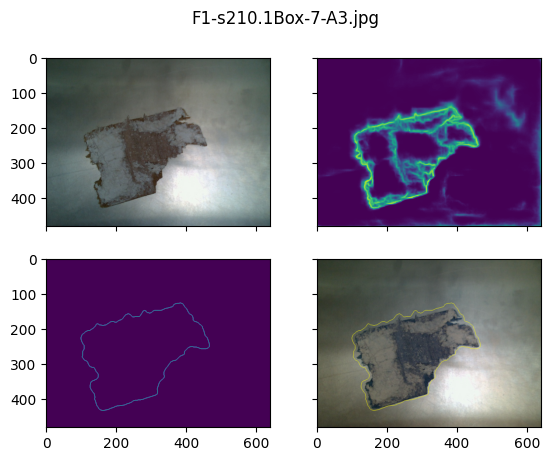

test\F1-s214Box-7-A3.jpg
Number of contours found =  14


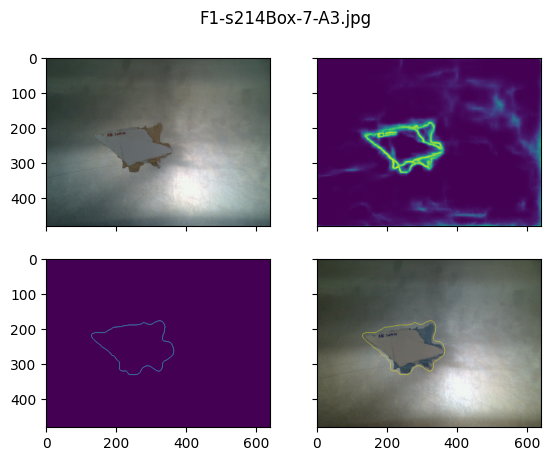

test\F1-s215Box-7-A3.jpg
Number of contours found =  20


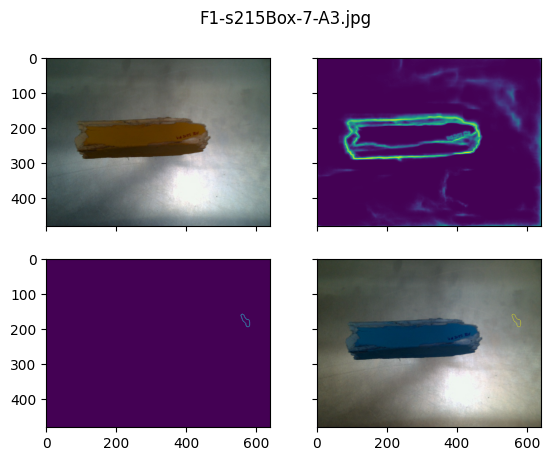

test\F1-s269Box-7-A3.jpg
Number of contours found =  11


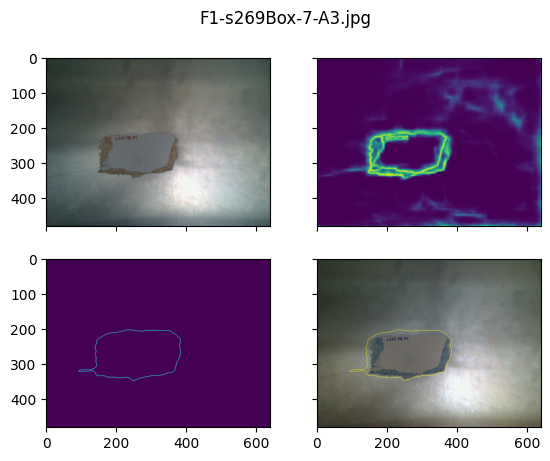

test\F1-s271Box-7-A3.jpg
Number of contours found =  1


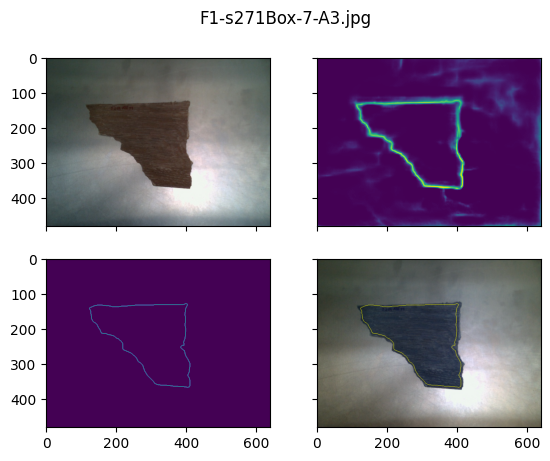

In [2]:
class_id=str(input('enter the class id (A1, A2 ,A3)......   ') )
for image in os.listdir('test'):
        print(os.path.join('test',image))
        maskki(os.path.join('test',image),image,class_id)